In [161]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import hippomaps as hm
import glob
from brainspace.gradient import GradientMaps


In [162]:
sub = '21'
den='0p5mm'
hemis = ["L","R"]
labels=['hipp']

nV,iV = hm.config.get_nVertices(labels,den)

# tSNR

In [163]:
vol = glob.glob(f"S1_{sub}_*_mctSNR.nii.gz")[0]

for hemi in hemis:
    cmd = f"wb_command -volume-to-surface-mapping {vol} "\
        f"hippunfold_v1.4.2/hippunfold/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T2w_den-0p5mm_label-hipp_midthickness.surf.gii "\
        f"hippunfold_v1.4.2/hippunfold/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T2w_den-0p5mm_label-hipp_tSNR.shape.gii -trilinear"
    !{cmd}

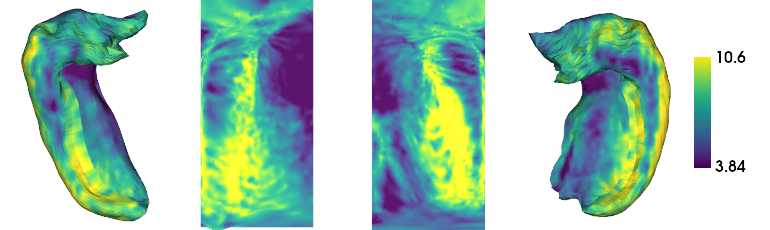

In [164]:
hm.plotting.surfplot_sub_foldunfold('hippunfold_v1.4.2/hippunfold',sub,'',['tSNR'],labels=['hipp'],modality='T2w', unfoldAPrescale=True, share='row', color_bar=True, embed_nb=True)

# Intrinsic timescale (in TRs; TR=2.4sec)

In [165]:
vol = glob.glob(f"S1_{sub}_*_mc.nii.gz")[0]

for hemi in hemis:
    cmd = f"wb_command -volume-to-surface-mapping {vol} "\
        f"hippunfold_v1.4.2/hippunfold/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T2w_den-0p5mm_label-hipp_midthickness.surf.gii "\
        f"hippunfold_v1.4.2/hippunfold/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T2w_den-0p5mm_label-hipp_ts.func.gii -trilinear"
    !{cmd}

In [166]:
samp = nib.load(f"hippunfold_v1.4.2/hippunfold/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T2w_den-0p5mm_label-hipp_ts.func.gii").darrays
print("timepoints: " + str(len(samp)))
hippdat = np.zeros((nV,len(hemis),len(samp)))
for h,hemi in enumerate(hemis):
    samp = nib.load(f"hippunfold_v1.4.2/hippunfold/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T2w_den-0p5mm_label-hipp_ts.func.gii").darrays
    for s in range(len(samp)):
        hippdat[:,h,s] = samp[s].data

timepoints: 165


In [167]:
def IntrinsicTimescale(data, TR=1, threshold=0):
    '''computes instrinsic timescale - the AUC of the autocorrelation up to the point
    where the autocorrelation reaches threshold.
    Input
      img: input ND data, time being the last dimension
    '''
    shp = data.shape
    i = data.reshape(-1, shp[-1])
    out = np.zeros(i.shape[0])
    for v in range(i.shape[0]):
        m = np.mean(i[v,:])
        var = np.var(i[v,:])
        ndat = i[v,:] - m
        acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:]
        acf = acf / var / len(ndat)
        f = np.where(acf<=threshold)[0]
        if len(f)==0:
            out[v] = np.nan
        else:
            out[v] = f[0]
    out = np.reshape(out,shp[:-1])*TR
    return out

In [168]:
hippdat.shape

(7262, 2, 165)

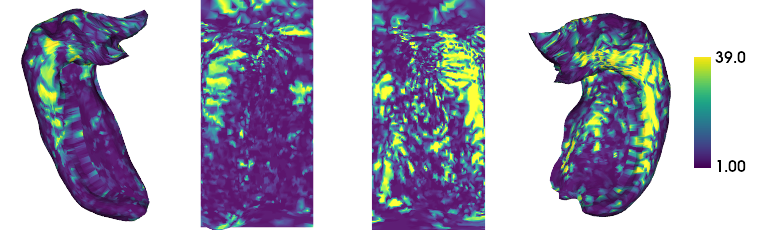

In [169]:
IntTS = np.ones((nV,len(hemis)))*np.nan
for h,hemi in enumerate(hemis):
    IntTS[:,h] = IntrinsicTimescale(hippdat[:,h,:])
    cdat = IntTS[:,h]
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f"hippunfold_v1.4.2/hippunfold/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T2w_den-0p5mm_label-hipp_intTS.shape.gii")

hm.plotting.surfplot_sub_foldunfold('hippunfold_v1.4.2/hippunfold',sub,'',['intTS'],labels=['hipp'],modality='T2w',share='row',color_bar=True,unfoldAPrescale=True, embed_nb=True)

# functional connectivity

In [170]:
FC = np.zeros((nV,nV,len(hemis)))
for h,hemi in enumerate(hemis):
    FC[:,:,h] = np.corrcoef(hippdat[:,h,:])

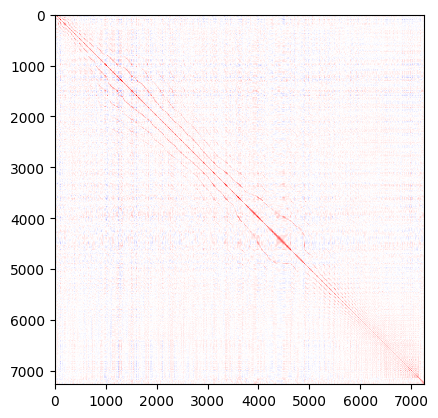

In [171]:
plt.imshow(FC[:,:,0], clim=[-0.5,0.5], cmap='bwr')

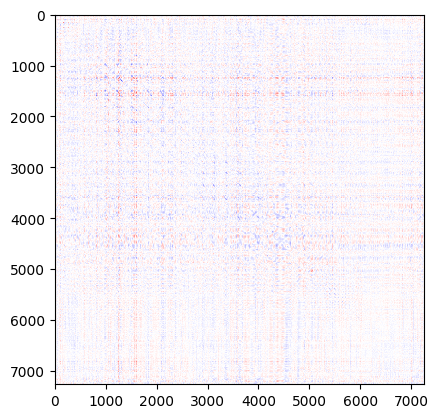

In [172]:
plt.imshow(FC[:,:,1]-FC[:,:,0], clim=[-0.5,0.5],cmap='bwr')

0.06123878790062328

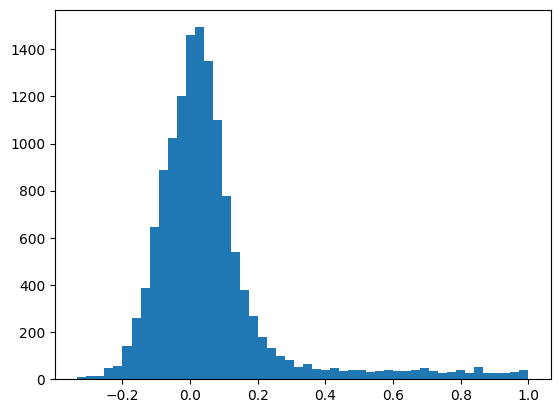

In [173]:
FCe = FC[:,:,h][np.triu_indices(len(samp),k=1)]
plt.hist(FCe,bins=50);
np.mean(FCe)

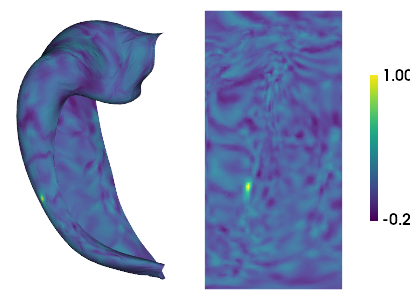

In [191]:
# example of a given vertex
hm.plotting.surfplot_canonical_foldunfold(FC[3550,:,0],hemis=['L'],labels=['hipp'],share='row',color_bar=True,unfoldAPrescale=True, embed_nb=True)

# FC gradients

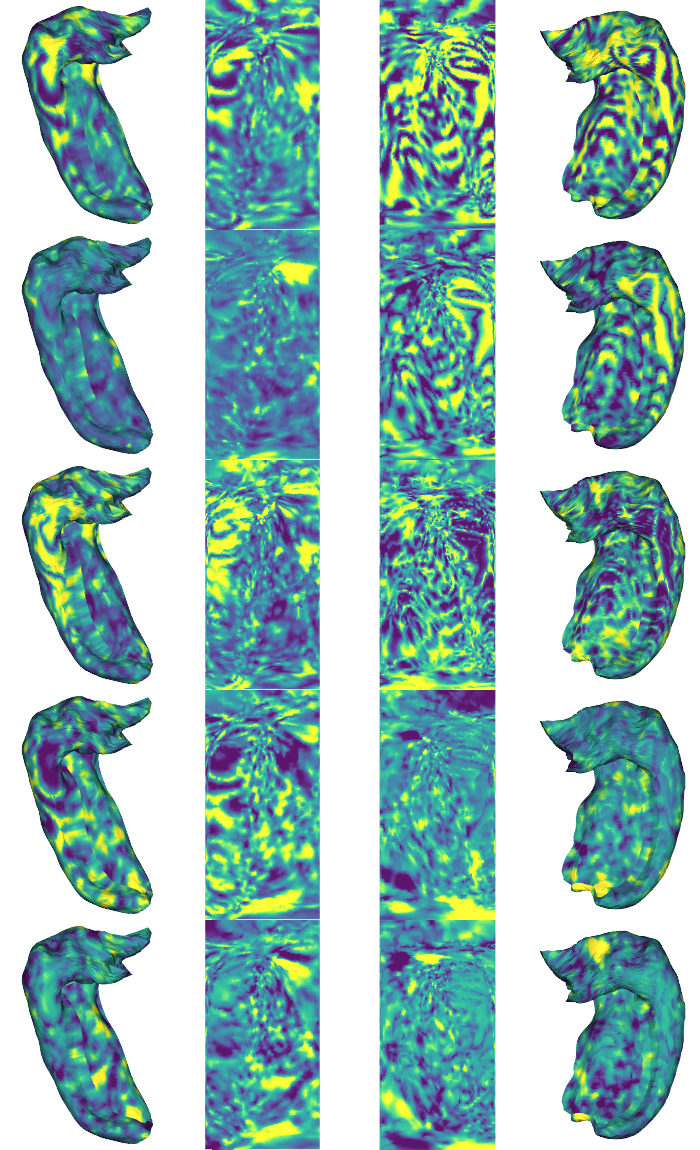

In [174]:
# no alignment between L<>R
for h,hemi in enumerate(hemis):
    FCGM = GradientMaps(n_components=5)
    FCGM.fit(FC[:,:,h])
    for g in range(5):
        cdat = FCGM.gradients_[:,g]
        data_array = nib.gifti.GiftiDataArray(data=cdat)
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        nib.save(image, f"hippunfold_v1.4.2/hippunfold/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T2w_den-0p5mm_label-hipp_gradient{g}.shape.gii")

hm.plotting.surfplot_sub_foldunfold('hippunfold_v1.4.2/hippunfold',sub,'',['gradient0','gradient1','gradient2','gradient3','gradient4'],labels=['hipp'],modality='T2w',unfoldAPrescale=True, embed_nb=True)

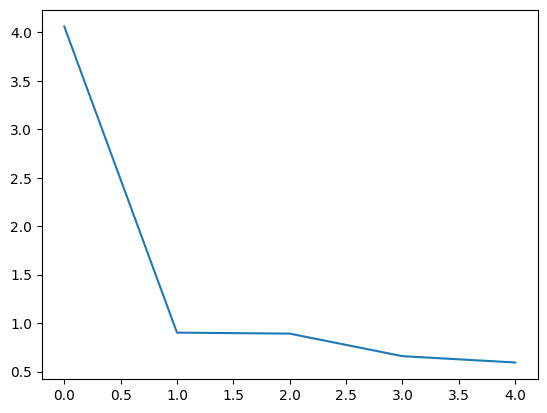

In [175]:
plt.plot(FCGM.lambdas_)